In this notebook, I evaluate different neural net models and save their performance (evaluted on mean absolute percent error) into a dataframe.

# Table of Contents
1. [Imports](#section1)
2. [Prepare DataFrame](#section2)
3. [Neural Net Model Evaluation](#section3)
4. [Making Model Error Dataframe](#section4)

<a id='section1'></a>

### 1. Imports

In [2]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

import time

%matplotlib inline

In [3]:
# neural net imports; need to be on Tensorflow kernel

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Input, Embedding, Bidirectional, LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


Using TensorFlow backend.
/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/tensorflow/l

<a id='section2'></a>

### 2. Prepare DataFrame

First, I'll need to prep my visitor dataframe into a format that's useful for time series. I'll start off by just cleaning up Yosemite's dataframe.

In [4]:
# using the Yosemite data as a test case
yosemite_df = pd.read_pickle("visitor_data/YOSE.pickle")

# clean up data and turn values into integers
yosemite_df.iloc[:,1:] = yosemite_df.iloc[:,1:].replace("\xa0", 0)
yosemite_df = yosemite_df.replace(",", '', regex=True).astype(int)

# will need to impute zero and low values with the mean
for column in yosemite_df.columns.tolist()[1:]:
    yosemite_df[column] = yosemite_df[column].map(lambda x: int(yosemite_df[column].mean()) if x < 100 else x)
    
yosemite_df.set_index("Year", inplace=True)

,Year,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,Total
0,2020,"132,742","167,778",0,0,0,"236,260","469,192",,,,,,"1,005,972"
1,2019,"116,746","111,665","173,610","297,207","393,004","496,625","717,462","703,153","584,664","448,939","230,598","149,188","4,422,861"
2,2018,"129,432","143,321","170,681","278,349","385,670","543,690","504,230","441,867","524,387","360,776","215,854","311,179","4,009,436"
3,2017,"120,025","119,421","166,793","302,553","471,844","565,702","633,351","615,892","566,279","429,827","217,927","127,276","4,336,890"
4,2016,"139,780","201,601","286,990","305,092","457,309","703,614","780,728","692,450","598,428","483,232","218,998","160,646","5,028,868"


Make a dataframe with each row representing a month and year with a column representing the number of visitors.

In [10]:
park_df = pd.DataFrame(yosemite_df.drop(columns=["Total"]).stack(), columns=["num_visitors"])

# turn the year and month strings into a datetime object
park_df.index = [(str(idx[0]) + " " + idx[1]) for idx in park_df.index]
park_df.index = pd.to_datetime(park_df.index, format="%Y %b")

# drop values for March 2020 and later due to the coronavirus pandemic
park_df = park_df[park_df.index < '2020-02-02']
park_df.sort_index(ascending=True, inplace=True)

num_visitors
Year                  
2020 JAN        132742
     FEB        167778
     MAR        136305
     APR        203944
     MAY        330180

<a id='section3'></a>

### 3. Neural Net Model Evaluation

The neural net models I evaluate are 
* Vanilla LSTM
* Stacked LSTM
* Bidirectional LSTM
* CNN LSTM

In [14]:
def prep_data(park_code):
    '''
    Clean and prep the dataframe related to the park code for time series modeling.
    Parameters:
    -----------
    - park_code: 4 letter park code (e.g. YOSE for Yosemite) that corresponds to a saved pickle file
    
    Returns:
    --------
    - park_df: cleaned dataframe ready to be used for neural net models
    
    '''
    
    # read in the dataframe
    park_df = pd.read_pickle(f"visitor_data/{park_code}.pickle")
    
    # clean up visitor number values and turn them into integers
    park_df.iloc[:,1:] = park_df.iloc[:,1:].replace("\xa0", 0)
    park_df = park_df.replace(",", '', regex=True).astype(int)
    
    # impute visitor values less than 100 with the mean visitor
    # count of that month
    for column in park_df.columns.tolist()[1:]:
        park_df[column] = park_df[column].map(lambda x: int(park_df[column].mean()) 
                                              if x < 100 else x)
    
    # make the index the date so that all values in the dataframe
    # are visitor counts
    park_df.set_index("Year", inplace=True)
    park_df.drop(columns=["Total"], inplace=True)
    
    # make the visitor counts into one column
    park_df = pd.DataFrame(park_df.stack(), columns=["num_visitors"])
    
    park_df.index = [(str(idx[0]) + " " + idx[1]) for idx in park_df.index]
    park_df.index = pd.to_datetime(park_df.index, format="%Y %b")
    
    # remove dates after February 2020 due to coronavirus effects
    # on visitor counts
    park_df = park_df[park_df.index < '2020-02-02']
    park_df.sort_index(ascending=True, inplace=True)
    
    return park_df

In [15]:
def split_data(data, n_steps):
    '''
    This function splits a univariate time series into sample sequences. For example, 
    given a sequence like [10, 20, 30, 40, 50] and a step size of 3, split the data into
    X: [10, 20, 30] and [20, 30, 40]
    Y: [40] and [50]
    
    Parameters:
    -----------
    - data: the full data to split into sample sequences
    - n-steps: number of data points per sequence
    
    Returns:
    ---------
    - x, y: arrays with the data split into sample sequences
    '''
    
    x, y = list(), list()
    
    for i in range(len(data)-n_steps):
        seq_x = data[i:i+n_steps]
        seq_y = data[i+n_steps]
        x.append(seq_x)
        y.append(seq_y)
        
    return np.array(x), np.array(y)

In [ ]:
# metric to gauge model performance: mean absolute percent error or MAPE
def mape(y_true, y_pred):
    '''
    Returns the mean absolute percent error of actual vs. predicted values
    
    Parameters:
    -----------
    - y_true: actual values
    - y_pred: predicted values
    
    Returns:
    ---------
    - mean absolute percent error
    '''
    # reshape to make them the same shape
    y_true, y_pred = np.array(y_true).reshape(-1,1), np.array(y_pred).reshape(-1,1)
    error = (y_true - y_pred) / y_true
    return np.mean(np.abs(error)) * 100

In [48]:
def evaluate_models(data, months, park_code):
    '''
    Evaluate different LSTM models and outputs an error dictionary containing errors for all the models.
    
    Parameters:
    -----------
    - data: the cleaned visitor count dataframe
    - months: the number of months to split the training and testing data into
    - park_code: the 4 letter code corresponding to a park (e.g. YOSE for Yosemite)
    
    Returns:
    --------
    - error_dict: dictionary with different model errors per park code
    '''
    error_dict = {}
    
    # split the data into training and testing
    train_data = data.copy().iloc[:len(data)-months]
    test_data = data.copy().iloc[len(data)-months:]
    
    
    # split the training and testing set into x and y sequences
    train_x, train_y = split_data(train_data["num_visitors"].tolist(), 12)
    test_x, test_y = split_data(test_data["num_visitors"].tolist(), 12)
    
    # the cnn lstm input data needs to have the following structure:
    # [samples, subsequences, timesteps, features]
    cnn_lstm_mape = cnn_lstm_error(train_x, train_y, test_x, test_y)
    
    # the model will expect the input component of training data to have dimensions:
    # [samples, timesteps, features]
    
    n_features = 1
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], n_features)
    test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], n_features)
    
    lstm_mape = lstm_error(train_x, train_y, test_x, test_y)
    stacked_lstm_mape = stacked_lstm_error(train_x, train_y, test_x, test_y)
    bidirectional_lstm_mape = bidirectional_lstm_error(train_x, train_y, test_x, test_y)
    
    error_dict["park_code"] = park_code
    error_dict["LSTM_mape"] = lstm_mape
    error_dict["stacked_LSTM_mape"] = stacked_lstm_mape
    error_dict["bidirectional_LSTM_mape"] = bidirectional_lstm_mape
    error_dict["CNN_LSTM_mape"] = cnn_lstm_mape
    
    return error_dict

In [49]:
def lstm_error(train_x, train_y, test_x, test_y):
    '''
    Train a basic LSTM and calculate mean percent error
    Parameters:
    -----------
    - train_x: the training input
    - train_y: the training output
    - test_x: the test input
    - test_y: the test output
    
    Returns:
    --------
    - error: the mean absolute percent error for this model
    
    '''
    
    lstm_model = Sequential()
    
    # input shape has (n_steps, n_features), so I have 12 steps because this is an annual pattern and 1 feature
    # the 1 feature is the number of visitors
    lstm_model.add(LSTM(50, activation='relu', input_shape=(12,1)))
    
    # here, the model has 50 LSTM units in the hidden layer and an output layer that predicts a single value
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mse')
    
    lstm_model.fit(train_x, train_y, epochs=200, verbose=0)
    
    predictions = lstm_model.predict(test_x, verbose=0)
    prediction_list = [num[0] for num in predictions]
    
    error = mape(test_y, prediction_list)
    
    return error

In [50]:
def stacked_lstm_error(train_x, train_y, test_x, test_y):
    '''
    Train a stacked LSTM and calculate mean percent error.
    Parameters:
    -----------
    - train_x: the training input
    - train_y: the training output
    - test_x: the test input
    - test_y: the test output
    
    Returns:
    --------
    - error: the mean absolute percent error for this model
    '''
    # stacked LSTM

    s_model = Sequential()

    # input shape has (n_steps, n_features), so I have 12 steps because this is an annual pattern and 1 feature
    # the 1 feature is the number of visitors
    s_model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(12, 1)))

    # add another layer
    s_model.add(LSTM(50, activation='relu'))

    # the output layer predicts a single value
    s_model.add(Dense(1))

    s_model.compile(optimizer='adam', loss='mse')
    
    
    s_model.fit(train_x, train_y, epochs=200, verbose=0)
    
    predictions = s_model.predict(test_x, verbose=0)
    prediction_list = [num[0] for num in predictions]
    
    error = mape(test_y, prediction_list)
    
    return error

In [51]:
def bidirectional_lstm_error(train_x, train_y, test_x, test_y):
    '''
    Train a bidirectional LSTM and calculate mean percent error.
    Parameters:
    -----------
    - train_x: the training input
    - train_y: the training output
    - test_x: the test input
    - test_y: the test output
    
    Returns:
    --------
    - error: the mean absolute percent error for this model
    '''
    # stacked LSTM

    b_model = Sequential()

    # input shape has (n_steps, n_features), so I have 12 steps because this is an annual pattern and 1 feature
    # the 1 feature is the number of visitors
    b_model.add(Bidirectional(LSTM(50, activation='relu', input_shape=(12, 1))))

    # the output layer predicts a single value
    b_model.add(Dense(1))

    b_model.compile(optimizer='adam', loss='mse')
    
    b_model.fit(train_x, train_y, epochs=200, verbose=0)
    
    predictions = b_model.predict(test_x, verbose=0)
    
    prediction_list = [num[0] for num in predictions]
    
    error = mape(test_y, prediction_list)
    
    return error
    

In [52]:
def cnn_lstm_error(train_x, train_y, test_x, test_y):
    '''
    Train a hybrid CNN LSTM and calculate mean percent error.
    Parameters:
    -----------
    - train_x: the training input
    - train_y: the training output
    - test_x: the test input
    - test_y: the test output
    
    Returns:
    --------
    - error: the mean absolute percent error for this model
    '''
    n_features = 1
    
    # for each sequence of 12, split into 4 samples with 3 sub-samples each
    n_seq = 4
    n_steps = 3

    train_x = train_x.reshape(train_x.shape[0], n_seq, n_steps, n_features)
    test_x = test_x.reshape(test_x.shape[0], n_seq, n_steps, n_features)
    
    # define the CNN LSTM
    c_model = Sequential()

    c_model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
    c_model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    c_model.add(TimeDistributed(Flatten()))
    c_model.add(LSTM(50, activation='relu'))
    c_model.add(Dense(1))
    c_model.compile(optimizer='adam', loss='mse')
    
    c_model.fit(train_x, train_y, epochs=200, verbose=0)
    
    predictions = c_model.predict(test_x, verbose=0)
    
    prediction_list = [num[0] for num in predictions]
    
    error = mape(test_y, prediction_list)
    
    return error

Test out my functions with Yosemite visitor data.

In [ ]:
yosemite_df = prep_data("YOSE")

train_data = yosemite_df.copy().iloc[:len(yosemite_df)-48]
test_data = yosemite_df.copy().iloc[len(yosemite_df)-48:]
    
# split the training and testing set into x and y sequences
train_x, train_y = split_data(train_data["num_visitors"].tolist(), 12)
test_x, test_y = split_data(test_data["num_visitors"].tolist(), 12)

n_features = 1
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], n_features)
test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], n_features) 

In [36]:
lstm_mape = lstm_error(train_x, train_y, test_x, test_y)
lstm_mape

21.258581679388595

In [19]:
stacked_lstm_mape = stacked_lstm_error(train_x, train_y, test_x, test_y)
stacked_lstm_mape

23.895080960872196

In [21]:
bidirectional_lstm_mape = bidirectional_lstm_error(train_x, train_y, test_x, test_y)
bidirectional_lstm_mape

11.15022141922999

In [41]:
# the CNN-LSTM model requires different inputs than the other neural net models
train_data = yosemite_df.copy().iloc[:len(yosemite_df)-48]
test_data = yosemite_df.copy().iloc[len(yosemite_df)-48:]
    
# split the training and testing set into x and y sequences
train_x, train_y = split_data(train_data["num_visitors"].tolist(), 12)
test_x, test_y = split_data(test_data["num_visitors"].tolist(), 12)

cnn_lstm_mape, prediction_list = cnn_lstm_error(train_x, train_y, test_x, test_y)
cnn_lstm_mape

19.550605493519964

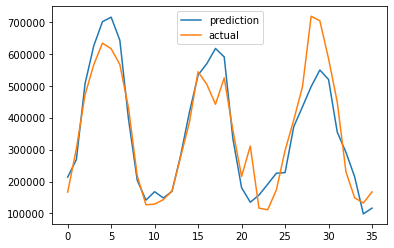

In [43]:
comparison = pd.DataFrame(prediction_list)
comparison["actual"] = pd.Series(test_y, index=comparison.index)
comparison = comparison.rename(columns={0:"prediction"})
comparison.plot();

In [54]:
error_dict = evaluate_models(yosemite_df, 48, "YOSE")
error_dict

{'park_code': 'YOSE',
 'LSTM_mape': 19.983445303430006,
 'stacked_LSTM_mape': 22.932013955024956,
 'bidirectional_LSTM_mape': 18.961654696486065,
 'CNN_LSTM_mape': 21.859690006628483}

<a id='section4'></a>

### 4. Making Model Error Dataframe

My functions work for Yosemite, so now it's time to populate the neural net model errors for all the other parks as well.

In [56]:
top_10_park_codes = ['ACAD',
 'GLAC',
 'GRCA',
 'GRTE',
 'GRSM',
 'OLYM',
 'ROMO',
 'YELL',
 'YOSE',
 'ZION']

In [57]:
error_list = []
for park in top_10_park_codes:
    error_dict = {}
    
    park_df = prep_data(park)
    
    error_dict = evaluate_models(park_df, 48, park)
    
    error_list.append(error_dict)
    
    time.sleep(60)

In [58]:
nn_model_error_df = pd.DataFrame(error_list)
nn_model_error_df

,park_code,LSTM_mape,stacked_LSTM_mape,bidirectional_LSTM_mape,CNN_LSTM_mape
0,ACAD,94.192380,108.689829,90.644033,65.476943
1,GLAC,221.535835,196.619597,147.262366,88.986315
2,GRCA,10.347758,20.873354,14.827679,13.542902
3,GRTE,65.115893,41.149050,28.733296,15.957406
4,GRSM,36.540512,28.679488,17.991664,14.753964
5,OLYM,18.138430,23.924357,62.703081,31.173866
6,ROMO,61.369693,18.488217,24.084228,21.320559
7,YELL,170.242646,86.947356,83.389727,73.676234
8,YOSE,19.771353,22.831845,22.021194,18.540834
9,ZION,27.479556,20.096860,19.468592,23.215827


In [59]:
nn_model_error_df.to_pickle("model_data/nn_model_error_df.pickle")

For my presentation, I would like to examine how the different neural net model predictions line up against the actual values. For example, I would like to examine why the LSTM models had such high error for Yellowstone.

In [30]:
yell_df =  prep_data('YELL')
pred_dict = model_predictions(yell_df, 48, 'YELL')

In [42]:
train_data = yell_df.copy().iloc[:len(yell_df)-48]
test_data = yell_df.copy().iloc[len(yell_df)-48:]
test_x, test_y = split_data(test_data["num_visitors"].tolist(), 12)

In [ ]:
x_test, y_test = list(), list()
for i in range(len(data)-n_steps):
    seq_x = test_data["num_visitors"].tolist()[i:i+n_steps]
    seq_y = test_data["num_visitors"].tolist()[i+n_steps]
    x.append(seq_x)
    y.append(seq_y)

In [29]:
def model_predictions(data, months, park_code):
    '''
    Evaluate different LSTM models and output predictions for models
    
    Parameters:
    -----------
    - data: the cleaned visitor count dataframe
    - months: the number of months to split the training and testing data into
    - park_code: the 4 letter code corresponding to a park (e.g. YOSE for Yosemite)
    
    Returns:
    --------
    - pred_dict: dictionary with different model predictions per park code
    '''
    pred_dict = {}
    
    # split the data into training and testing
    train_data = data.copy().iloc[:len(data)-months]
    test_data = data.copy().iloc[len(data)-months:]
    
    
    # split the training and testing set into x and y sequences
    train_x, train_y = split_data(train_data["num_visitors"].tolist(), 12)
    test_x, test_y = split_data(test_data["num_visitors"].tolist(), 12)
    
    # the cnn lstm input data needs to have the following structure:
    # [samples, subsequences, timesteps, features]
    cnn_lstm_pred = cnn_lstm_predict(train_x, train_y, test_x, test_y)
    
    # the model will expect the input component of training data to have dimensions:
    # [samples, timesteps, features]
    
    n_features = 1
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], n_features)
    test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], n_features)
    
    lstm_pred = lstm_predict(train_x, train_y, test_x, test_y)
    stacked_lstm_pred = stacked_lstm_predict(train_x, train_y, test_x, test_y)
    bidirectional_lstm_pred = bidirectional_lstm_predict(train_x, train_y, test_x, test_y)
    
    
    pred_dict["park_code"] = park_code
    pred_dict["LSTM_pred"] = lstm_pred
    pred_dict["stacked_LSTM_pred"] = stacked_lstm_pred
    pred_dict["bidirectional_pred"] = bidirectional_lstm_pred
    pred_dict["CNN_LSTM_pred"] = cnn_lstm_pred
    
    return pred_dict

In [24]:
def lstm_predict(train_x, train_y, test_x, test_y):
    '''
    Train a basic LSTM and calculate a prediction
    Parameters:
    -----------
    - train_x: the training input
    - train_y: the training output
    - test_x: the test input
    - test_y: the test output
    
    Returns:
    --------
    - error: the mean absolute percent error for this model    

    '''
    
    lstm_model = Sequential()
    
    # input shape has (n_steps, n_features), so I have 12 steps because this is an annual pattern and 1 feature
    # the 1 feature is the number of visitors
    lstm_model.add(LSTM(50, activation='relu', input_shape=(12,1)))
    
    # here, the model has 50 LSTM units in the hidden layer and an output layer that predicts a single value
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mse')
    
    lstm_model.fit(train_x, train_y, epochs=200, verbose=0)
    
    predictions = lstm_model.predict(test_x, verbose=0)
    prediction_list = [num[0] for num in predictions]
    
    return prediction_list

In [25]:
def stacked_lstm_predict(train_x, train_y, test_x, test_y):
    '''
    Train a stacked LSTM and calculate a prediction
    Parameters:
    -----------
    - train_x: the training input
    - train_y: the training output
    - test_x: the test input
    - test_y: the test output
    
    Returns:
    --------
    - error: the mean absolute percent error for this model
    '''
    # stacked LSTM

    s_model = Sequential()

    # input shape has (n_steps, n_features), so I have 12 steps because this is an annual pattern and 1 feature
    # the 1 feature is the number of visitors
    s_model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(12, 1)))

    # add another layer
    s_model.add(LSTM(50, activation='relu'))

    # the output layer predicts a single value
    s_model.add(Dense(1))

    s_model.compile(optimizer='adam', loss='mse')
    
    
    s_model.fit(train_x, train_y, epochs=200, verbose=0)
    
    predictions = s_model.predict(test_x, verbose=0)
    prediction_list = [num[0] for num in predictions]
    
    return prediction_list

In [26]:
def bidirectional_lstm_predict(train_x, train_y, test_x, test_y):
    '''
    Train a bidirectional LSTM and calculate a prediction
    Parameters:
    -----------
    - train_x: the training input
    - train_y: the training output
    - test_x: the test input
    - test_y: the test output
    
    Returns:
    --------
    - error: the mean absolute percent error for this model
    '''
    # stacked LSTM

    b_model = Sequential()

    # input shape has (n_steps, n_features), so I have 12 steps because this is an annual pattern and 1 feature
    # the 1 feature is the number of visitors
    b_model.add(Bidirectional(LSTM(50, activation='relu', input_shape=(12, 1))))

    # the output layer predicts a single value
    b_model.add(Dense(1))

    b_model.compile(optimizer='adam', loss='mse')
    
    b_model.fit(train_x, train_y, epochs=200, verbose=0)
    
    predictions = b_model.predict(test_x, verbose=0)
    
    prediction_list = [num[0] for num in predictions]
    
    return prediction_list

In [27]:
def cnn_lstm_predict(train_x, train_y, test_x, test_y):
    '''
    Train a hybrid CNN LSTM and calculate a prediction
    Parameters:
    -----------
    - train_x: the training input
    - train_y: the training output
    - test_x: the test input
    - test_y: the test output
    
    Returns:
    --------
    - error: the mean absolute percent error for this model
    '''
    n_features = 1
    
    # for each sequence of 12, split into 4 samples with 3 sub-samples each
    n_seq = 4
    n_steps = 3

    train_x = train_x.reshape(train_x.shape[0], n_seq, n_steps, n_features)
    test_x = test_x.reshape(test_x.shape[0], n_seq, n_steps, n_features)
    
    # define the CNN LSTM
    c_model = Sequential()

    c_model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
    c_model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    c_model.add(TimeDistributed(Flatten()))
    c_model.add(LSTM(50, activation='relu'))
    c_model.add(Dense(1))
    c_model.compile(optimizer='adam', loss='mse')
    
    c_model.fit(train_x, train_y, epochs=200, verbose=0)
    
    predictions = c_model.predict(test_x, verbose=0)
    
    prediction_list = [num[0] for num in predictions]
    
    return prediction_list

In [62]:
comparison_1 = pd.DataFrame(pred_dict["LSTM_pred"])
comparison_1["actual"] = pd.Series(test_data["num_visitors"].values.tolist()[:36], index=comparison_1.index)
comparison_1 = comparison_1.rename(columns={0:"prediction"})
comparison_1.index = test_data.index.tolist()[:36]

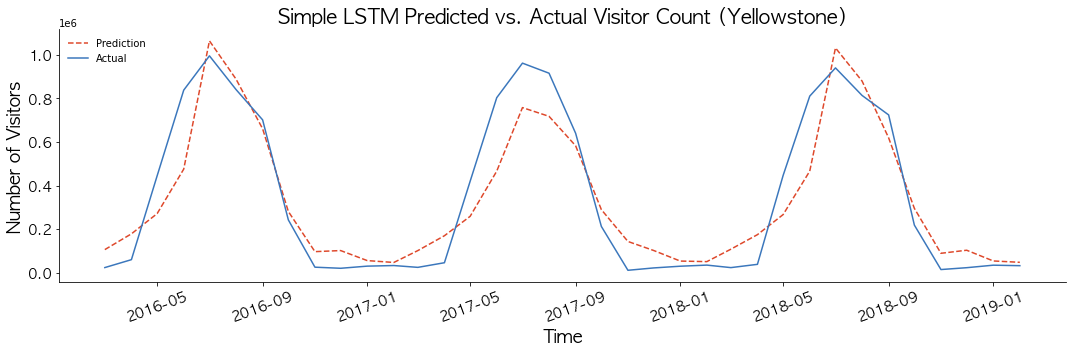

In [76]:
# plot yellowstone LSTM predictions
plt.figure(figsize=(15,5))

plt.plot(comparison_1.index, comparison_1["prediction"], label="prediction", color='#DE482B', linestyle='--')
sns.lineplot(x=comparison_1.index, y=comparison_1["actual"], label="actual", color='#3B77BC')

sns.despine(top=True, right=True)

legend = plt.legend(bbox_to_anchor=(0,1), loc="upper left", frameon=False)
legend.texts[0].set_text("Prediction")
legend.texts[1].set_text("Actual")

plt.title("Simple LSTM Predicted vs. Actual Visitor Count (Yellowstone)", fontsize=20, fontname="AppleGothic")

plt.xlabel("Time", fontname="AppleGothic", fontsize=18)
plt.ylabel("Number of Visitors", fontname="AppleGothic", fontsize=18)

plt.xticks(rotation=20, fontname="AppleGothic", fontsize=14)
plt.yticks(fontname="AppleGothic", fontsize=14)
plt.tight_layout()

plt.savefig('images/simple_lstm_forecast.png', format='png', dpi=400, transparent=True);

In [64]:
comparison_2 = pd.DataFrame(pred_dict["stacked_LSTM_pred"])
comparison_2["actual"] = pd.Series(test_data["num_visitors"].values.tolist()[:36], index=comparison_2.index)
comparison_2 = comparison_2.rename(columns={0:"prediction"})
comparison_2.index = test_data.index.tolist()[:36]

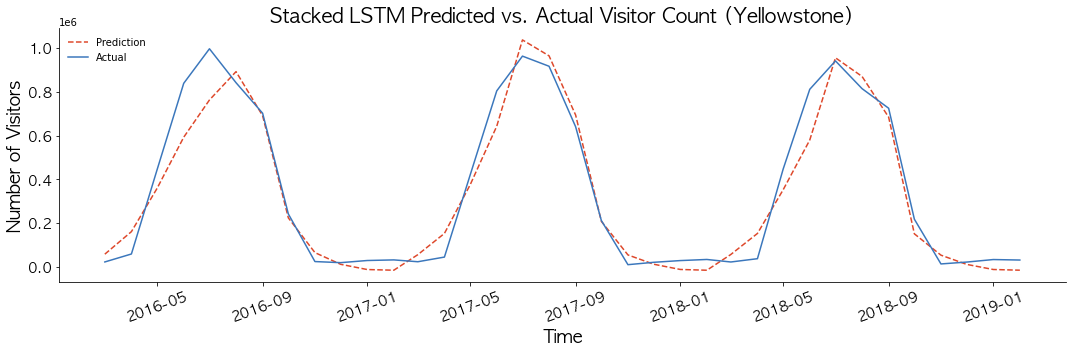

In [77]:
plt.figure(figsize=(15,5))

plt.plot(comparison_2.index, comparison_2["prediction"], label="prediction", color='#DE482B', linestyle='--')
sns.lineplot(x=comparison_2.index, y=comparison_2["actual"], label="actual", color='#3B77BC')

sns.despine(top=True, right=True)

legend = plt.legend(bbox_to_anchor=(0,1), loc="upper left", frameon=False)
legend.texts[0].set_text("Prediction")
legend.texts[1].set_text("Actual")

plt.title("Stacked LSTM Predicted vs. Actual Visitor Count (Yellowstone)", fontsize=20, fontname="AppleGothic")

plt.xlabel("Time", fontname="AppleGothic", fontsize=18)
plt.ylabel("Number of Visitors", fontname="AppleGothic", fontsize=18)

plt.xticks(rotation=20, fontname="AppleGothic", fontsize=14)
plt.yticks(fontname="AppleGothic", fontsize=14)
plt.tight_layout()

plt.savefig('images/stacked_lstm_forecast.png', format='png', dpi=400, transparent=True);

In [66]:
comparison_3 = pd.DataFrame(pred_dict["bidirectional_pred"])
comparison_3["actual"] = pd.Series(test_data["num_visitors"].values.tolist()[:36], index=comparison_3.index)
comparison_3 = comparison_3.rename(columns={0:"prediction"})
comparison_3.index = test_data.index.tolist()[:36]

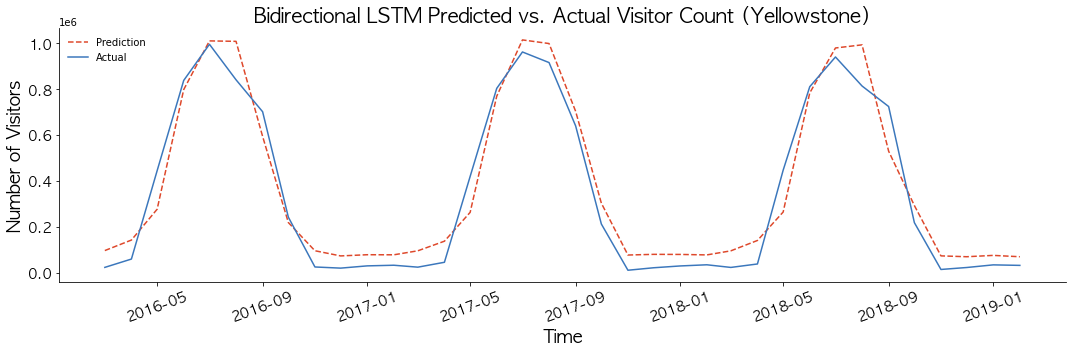

In [78]:
plt.figure(figsize=(15,5))

plt.plot(comparison_3.index, comparison_3["prediction"], label="prediction", color='#DE482B', linestyle='--')
sns.lineplot(x=comparison_3.index, y=comparison_3["actual"], label="actual", color='#3B77BC')

sns.despine(top=True, right=True)

legend = plt.legend(bbox_to_anchor=(0,1), loc="upper left", frameon=False)
legend.texts[0].set_text("Prediction")
legend.texts[1].set_text("Actual")

plt.title("Bidirectional LSTM Predicted vs. Actual Visitor Count (Yellowstone)", fontsize=20, fontname="AppleGothic")

plt.xlabel("Time", fontname="AppleGothic", fontsize=18)
plt.ylabel("Number of Visitors", fontname="AppleGothic", fontsize=18)

plt.xticks(rotation=20, fontname="AppleGothic", fontsize=14)
plt.yticks(fontname="AppleGothic", fontsize=14)
plt.tight_layout()

plt.savefig('images/bidirectional_lstm_forecast.png', format='png', dpi=400, transparent=True);

In [80]:
mape(test_data["num_visitors"].values.tolist()[:36], pred_dict["CNN_LSTM_pred"])

53.191409887885456

In [70]:
comparison_4 = pd.DataFrame(pred_dict["CNN_LSTM_pred"])
comparison_4["actual"] = pd.Series(test_data["num_visitors"].values.tolist()[:36], index=comparison_4.index)
comparison_4 = comparison_4.rename(columns={0:"prediction"})
comparison_4.index = test_data.index.tolist()[:36]

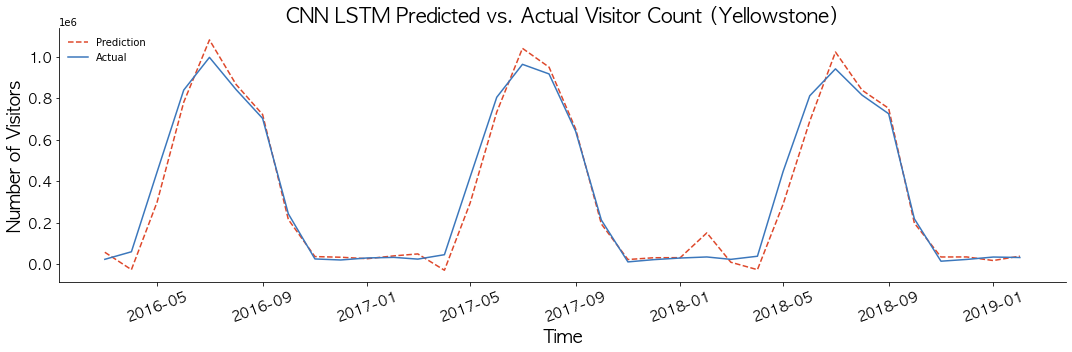

In [79]:
plt.figure(figsize=(15,5))

plt.plot(comparison_4.index, comparison_4["prediction"], label="prediction", color='#DE482B', linestyle='--')
sns.lineplot(x=comparison_4.index, y=comparison_4["actual"], label="actual", color='#3B77BC')

sns.despine(top=True, right=True)

legend = plt.legend(bbox_to_anchor=(0,1), loc="upper left", frameon=False)
legend.texts[0].set_text("Prediction")
legend.texts[1].set_text("Actual")

plt.title("CNN LSTM Predicted vs. Actual Visitor Count (Yellowstone)", fontsize=20, fontname="AppleGothic")

plt.xlabel("Time", fontname="AppleGothic", fontsize=18)
plt.ylabel("Number of Visitors", fontname="AppleGothic", fontsize=18)

plt.xticks(rotation=20, fontname="AppleGothic", fontsize=14)
plt.yticks(fontname="AppleGothic", fontsize=14)
plt.tight_layout()

plt.savefig('images/cnn_lstm_forecast.png', format='png', dpi=400, transparent=True);